<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Библиотеки
# вывод
import time
from tqdm.notebook import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
# данные
import numpy as np
import pandas as pd
# графика
import matplotlib.pyplot as plt
import seaborn as sns
# анализ
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# модели
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
print("\nIs the index sorted:", df.index.is_monotonic)
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Is the index sorted: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Даты в индексе отсортированы, идут по порядку

Ресемплируем датасет, сгруппируем данные на часовые интервалы, просуммируем значения количества заказов на интервалах

In [3]:
df = df.resample('1H').sum()
y = df['num_orders']
y

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

## Анализ

In [4]:
def plot_time_series(series, roll_size=24):
    """
    Функция построения графика временного ряда со скользящим средним и 
    стандартным отклонением по окну заданного размера
    
    Принимает
        : `series` - pd.Series - временной ряд  
        : `roll_size` - int - размер окна
    """
    pd.DataFrame({series.name: series,
                  'rolling_mean': series.rolling(roll_size).mean(),
                  'rolling_std': series.rolling(roll_size).std()}
                 ).plot(figsize=(16.5, 5))
    plt.grid()
    plt.xlabel("Time interval: %s - %s" %
               (series.index.min(), series.index.max()))
    plt.ylabel(series.name)
    plt.title("Time series of '%s' (rolling size = %i hours)" %
              (series.name, roll_size))


def compare_distributions(series, splits=[], tot=False):
    """Функция построения распределений величин временного ряда для заданный интервалов
    
    Принимает
        : `series`-  pd.Series - временной ряд
        : `splits` - list - список из вложенных списков с началом и концом интервалов, 
        на которых необходимо построить распределения 
        : `tot` - bool - флаг строить ли гистограмму для всего ряда
    """
    legend = []
    _, ax = plt.subplots(figsize=(12, 6))
    
    if tot:
        legend.append('total dataset')
        sns.histplot(series, bins=100, color='lightgrey', ax=ax)

    cmap = plt.get_cmap('rainbow')
    for i in range(len(splits)):
        s = splits[i]
        legend.append(' - '.join(s))
        X = series[s[0]:s[1]]
        print('%s : mean = %f, std = %f ' % (legend[-1], X.mean(), X.std()))
        sns.histplot(X, bins=50, ax=ax, color=cmap(i/len(splits)))

    ax.set(ylabel='Count of values', xlabel=series.name,
           title='Distribution of %s' % series.name)
    plt.grid()
    plt.legend(legend)


def plot_average_by_period(series, x, hue=None, xstep=2, tot=False):
    """Функция построения зависимости значений в `series` от временного промежутка `x` 
    с группмровкой по `hue`
    """
    _, ax = plt.subplots(figsize=(16.5,5))
    try:
        x_ = getattr(series.index, x)
    except:
        print("Can't find '{}'".format(x))
        return
    title = "Dependence of '%s' on '%s'" % (series.name, x)

    if hue is not None:
        hue_ = getattr(series.index, hue)
        palette = sns.color_palette("husl", len(hue_.unique()))
        sns.lineplot(x=x_, y=series.values, hue=hue_, palette=palette)
        ax.legend(title=hue)
        title += " for different '%s'" % hue
    if tot:
        sns.lineplot(x=x_, y=series.values, color='black')
    title += " on period %s - %s" % (series.index.min(), series.index.max())
    ax.legend(title=hue)
    ax.set(xlabel=x, xlim=(x_.min(), x_.max()),
           xticks=(np.arange(x_.min(), x_.max()+1, xstep)),
           title=title)
    plt.grid()
    plt.show()

Исходный временной ряд

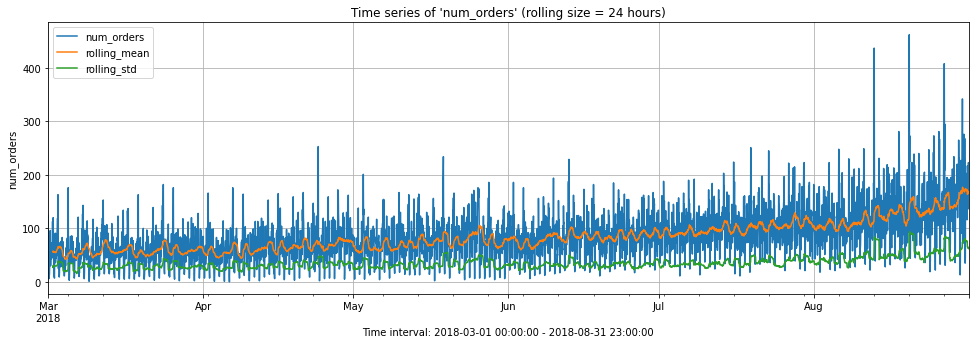

In [5]:
plot_time_series(y, 24)

Сложно говорить о стационарности ряда, есть тренд на рост. А также с течением времени растёт дисперсия ряда.
Посмотрим также на временной рад на интервале последнего месяца и последней недели

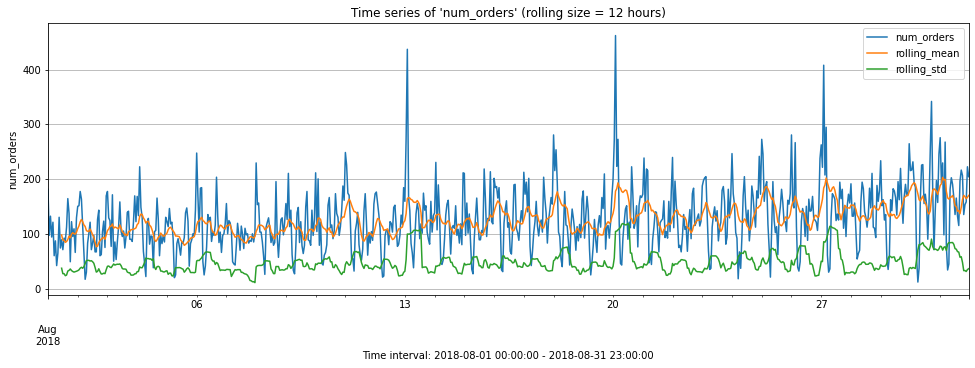

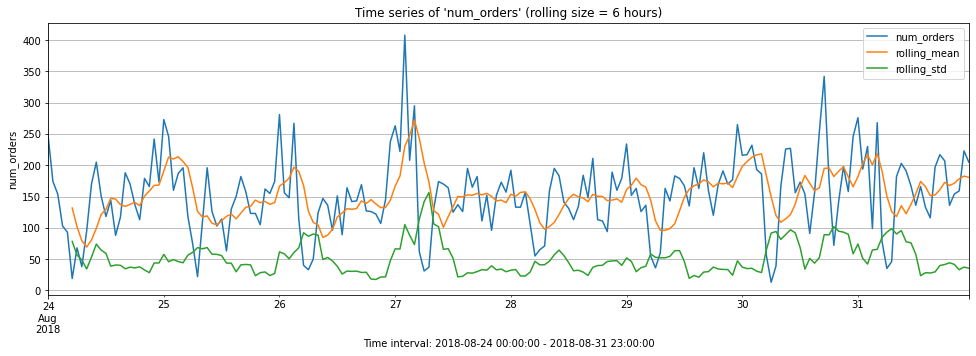

In [6]:
plot_time_series(y['2018-08-01':'2018-08-31'], 12)
plot_time_series(y['2018-08-24':'2018-08-31'], 6)

Есть сезонность по дням и по неделям
Построим зависимость среднего числа заказов от часа для каждого месяца А также построим такие зависимости для последних двух месяцев по неделям

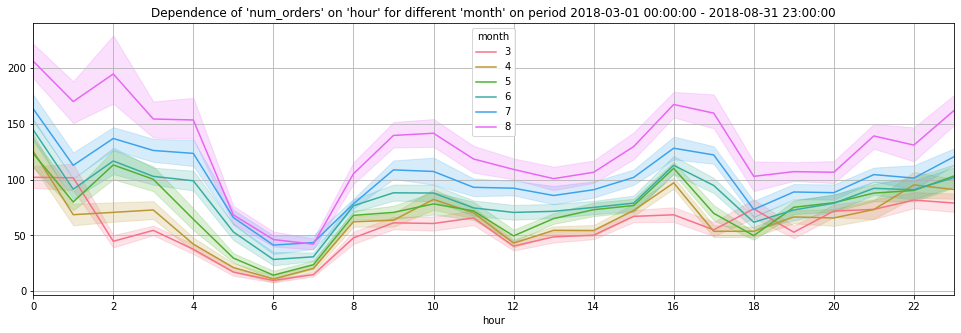

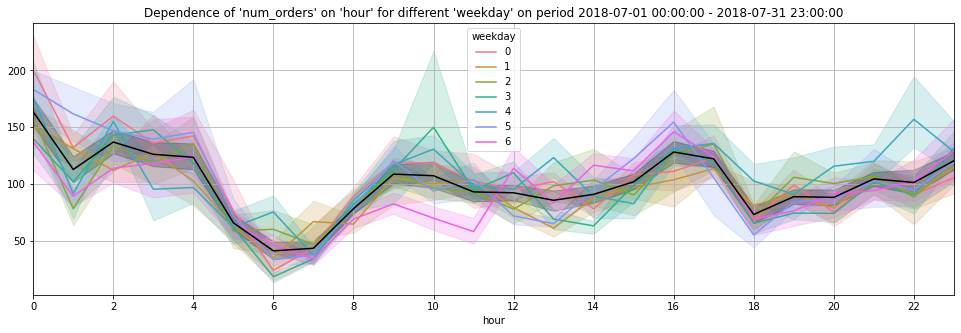

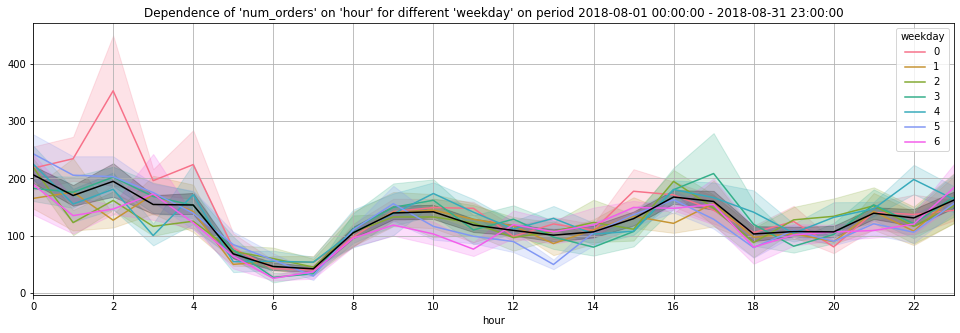

In [7]:
plot_average_by_period(y, x='hour', hue='month')
plot_average_by_period(y['2018-07-01':'2018-07-31'], x='hour', hue='weekday', tot=True)
plot_average_by_period(y['2018-08-01':'2018-08-31'], x='hour', hue='weekday', tot=True)



На последних двух графиках чёрные линии соответсвуюи графикам для июля и августа на первом графике.

Наблюдаем периодичность зависимости ряда от времени суток: с 0 часов до 6-7 наблюдается спад количества заказов, с 6 до 10 и с 18 до полуночи рост.
Таким образом:

    имеется посуточная сезонность,
    имеется понедельная сезонность,
    количество заказов зависит от часа суток, дня недели

Проверка на стационарность

Проанализируем распределения количества заказов на всём временном ряде и на последних нескольких месяцах


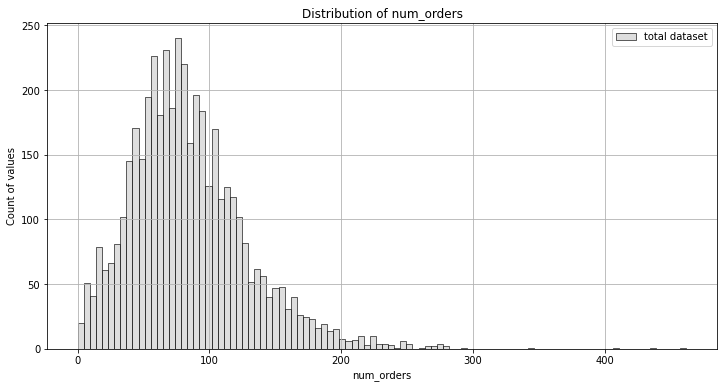

In [8]:
compare_distributions(y, tot=True)

2018-05-01 - 2018-05-31 : mean = 73.682796, std = 34.849825 
2018-06-01 - 2018-06-30 : mean = 83.202778, std = 32.826776 
2018-07-01 - 2018-07-31 : mean = 100.006720, std = 37.254770 
2018-08-01 - 2018-08-31 : mean = 127.651882, std = 56.242228 


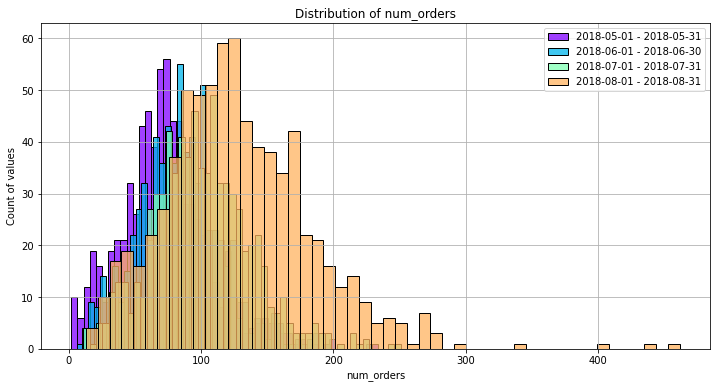

In [9]:
splits = [['2018-05-01', '2018-05-31'],
          ['2018-06-01', '2018-06-30'],
          ['2018-07-01', '2018-07-31'],
          ['2018-08-01', '2018-08-31']]

compare_distributions(y, splits=splits)



    Максимум распределения по месяцам смещается вправо, для августа смещение сильнее по отношению к предыдущим месяцам
    Также видим, что выбросы проявляются в основном только в последнем из рассмотренных месяцев. Возможно, это связано с тем, что в августе сезон отпусков и больше пассажиров заказывают такси из аэропорта



Воспользуемся дополнительным тестом Дики-Фуллера

Нулевая гипотеза (H0) - временной ряд нестационарен (имеет зависимость от времени).
Альтернативная гипотеза (H1) - временной ряд является стационарным.

Результат теста определяется по p-значению теста.
Выбор порогового значения p-value равным 5%, означает:

    p-value > 0,05: не удается отвергнуть нулевую гипотезу (H0), ряд нестационарный.
    p-value <= 0,05: отклоняем нулевую гипотезу (H0), ряд стационарный.


In [10]:
def adfuller_test(series, pvalue, regression='c'):
    """ Просто вывод результата теста Дики-Фуллера
    """
    result = adfuller(series, regression=regression)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print()
    if result[1] <= pvalue:
        print('Ряд стационарный по критерию Дики-Фуллера')
    else:
        print('Ряд НЕстационарный по критерию Дики-Фуллера')

При выполнении функции будет выведено значение статистики, полученной на тесте, p-значение теста и значения статистик, соответсвующих уровням значимости 1, 5 и 10 процентов.

In [11]:
adfuller_test(y, 0.05)

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Ряд стационарный по критерию Дики-Фуллера


**Тренды и сезонность**

In [12]:
def seasonal_decompose_plots(decomposition, out='otsr'):
    """ Функция для более удобного вывода графификов из результата работы функции
    `tsa.seasonal.seasonal_decompose()`

    Принимает 
    : `decomposition` - объект структуры DecomposeResult
    : `out` - строка с ключами необходимых для вывода графиков 
            (`o` - observed, `t` - trend, `s` - seasonal, `r` - resid)
    """
    if len(out) < 1:
        return print('Nothing to show')
    
    _, axs = plt.subplots(len(out), figsize=(16.5, 3*len(out)))
    if len(out) == 1:
        axs.set_title("Seasonal decomposition")
        axs = {out: axs}
    else:
        axs[0].set_title("Seasonal decomposition")
        axs = {p: axs[i] for p, i in zip(out, range(len(out)))}

    if 'o' in out:    
        decomposition.observed.plot(ax=axs['o'], color='darkblue', grid=True,
                                    ylabel='Observed', xlabel='')
    if 't' in out:
        decomposition.trend.plot(ax=axs['t'],  color='darkorange', grid=True,
                                 ylabel='Trend', xlabel='')
    if 's' in out:
        decomposition.seasonal.plot(ax=axs['s'], color='darkgreen', grid=True,
                                    ylabel='Seasonal', xlabel='')
    if 'r' in out:
        decomposition.resid.plot(ax=axs['r'],  color='darkred', grid=True,
                                 ylabel='Residual', xlabel='')

Получим тренд и сезонность на всём временном ряду

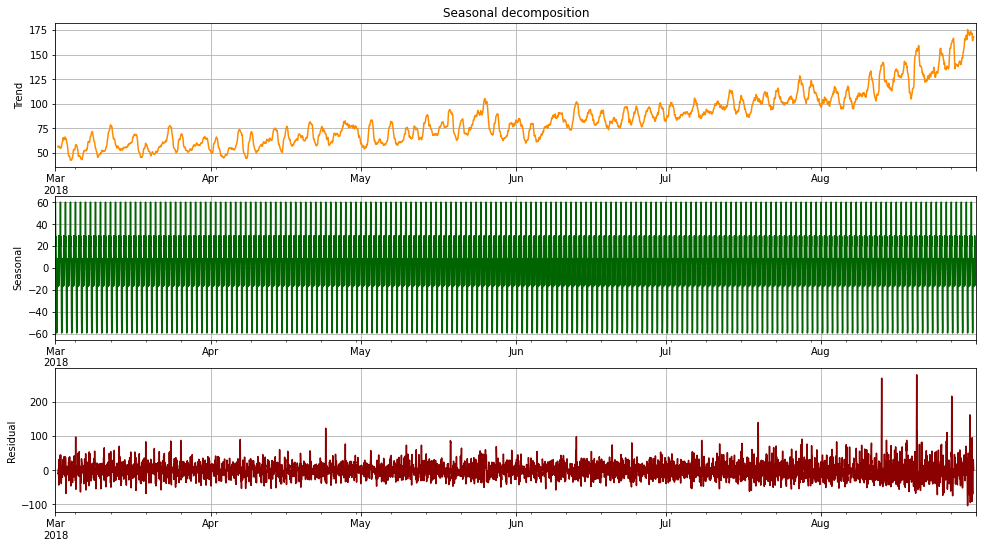

In [13]:
seasonal_decompose_plots(seasonal_decompose(y), 'tsr')

Посмотрим только на последний месяц

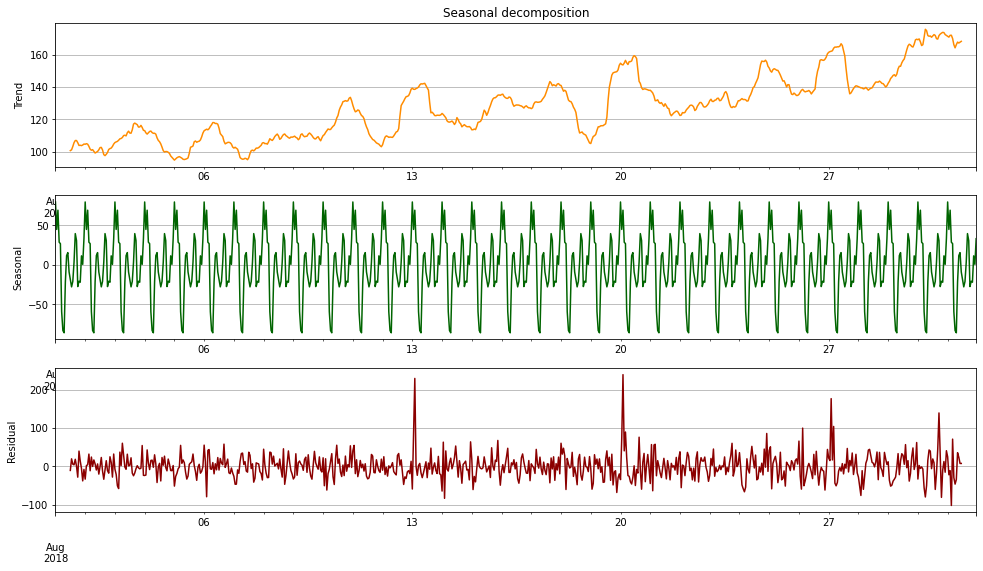

In [14]:
seasonal_decompose_plots(seasonal_decompose(y['2018-08-01':'2018-08-31']), 'tsr')

Наблюдаем обраруженную ранее сезонность по дням
В тренде также возможно присутсвует периодичность. Рассмотрим последние недели июля и августа

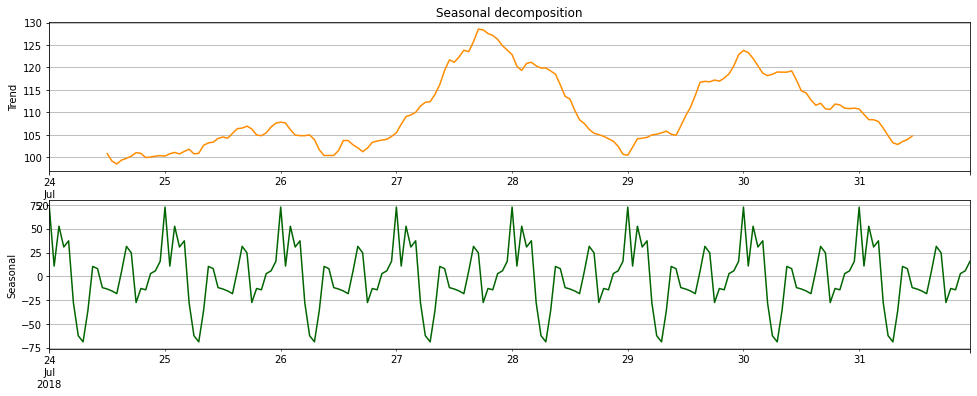

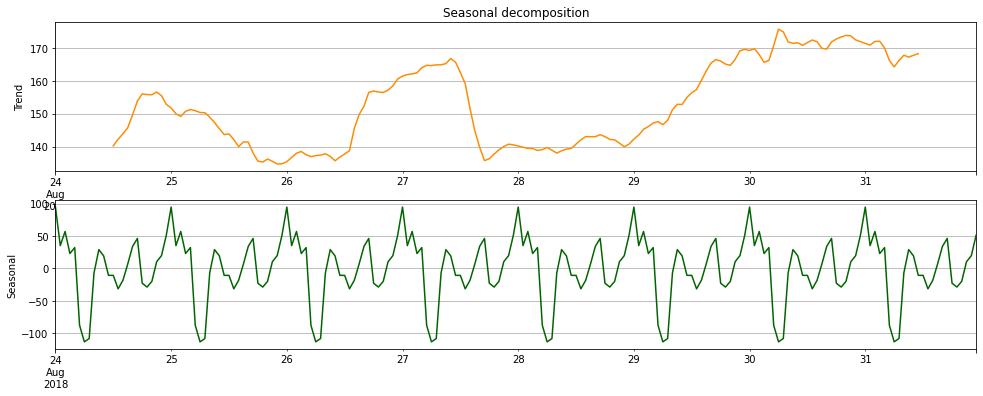

In [15]:
seasonal_decompose_plots(seasonal_decompose(y['2018-07-24':'2018-07-31']), 'ts')
seasonal_decompose_plots(seasonal_decompose(y['2018-08-24':'2018-08-31']), 'ts')

Сезонность по дням практически одинаковая
Посмотрим тренд на датасете ресемплированном по дням

    найдём для каждого дня среднее число заказов в час в течение дня
    построим тренд и сезонность
    отдельно посмотрим на сезонность за последние 2 месяца

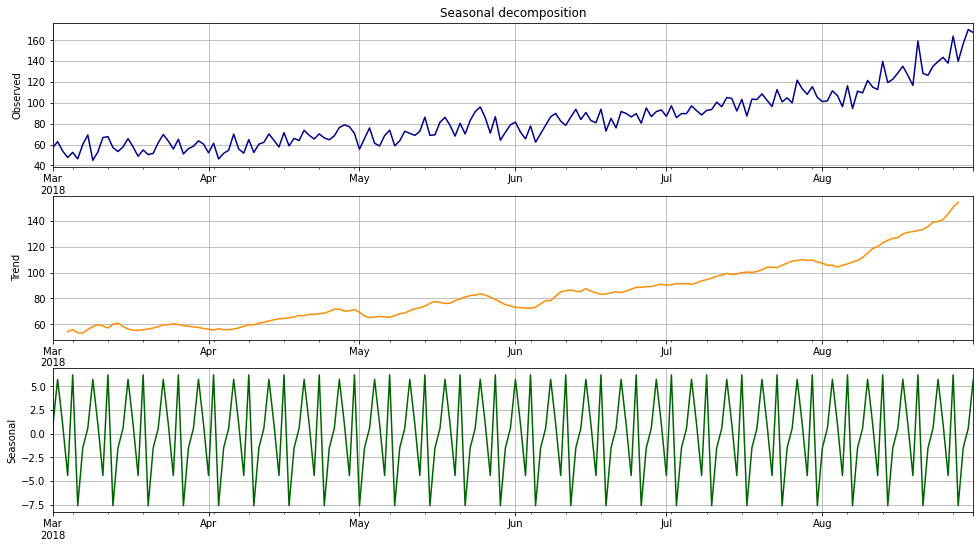

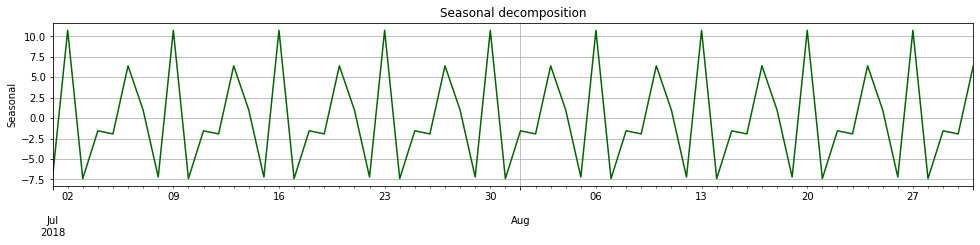

In [16]:
seasonal_decompose_plots(seasonal_decompose(y.resample('1D').mean()), 'ots')
seasonal_decompose_plots(seasonal_decompose(
    y.resample('1D').mean()['2018-07-01':'2018-08-31']), 's')

    Периодичность в тренде исчезла, однако растёт он в разные месяцы с разной скоростью
    Есть провалы в росте тренда в начале каждого месяца
    Замечаем сезонность по неделям

Построим временной ряд на разности с соседними значениями

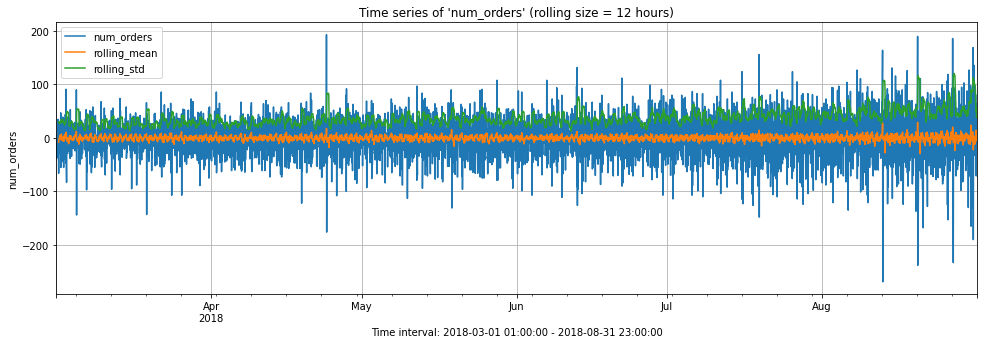

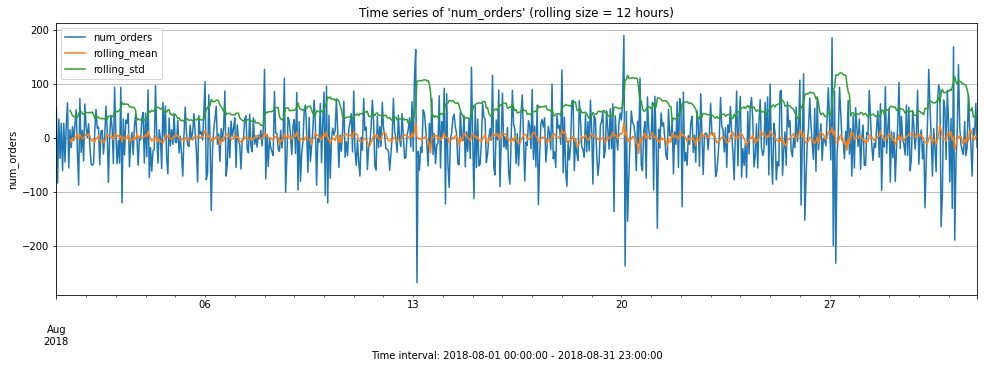

In [17]:
y_sh = (y-y.shift(1)).dropna()
plot_time_series(y_sh, 12)
plot_time_series(y_sh['2018-08-01':'2018-08-31'], 12)

Тренд на рост исчез, но дисперсия по прежнему велика.
Здесь уже сложнее говорить о сезонности

ADF Statistic: -15.793234257410534
p-value: 1.0958776746509151e-28
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

Ряд стационарный по критерию Дики-Фуллера

2018-05-01 - 2018-05-31 : mean = 0.069892, std = 33.954811 
2018-06-01 - 2018-06-30 : mean = 0.006944, std = 35.573250 
2018-07-01 - 2018-07-31 : mean = -0.012097, std = 42.074901 
2018-08-01 - 2018-08-31 : mean = 0.107527, std = 54.905736 


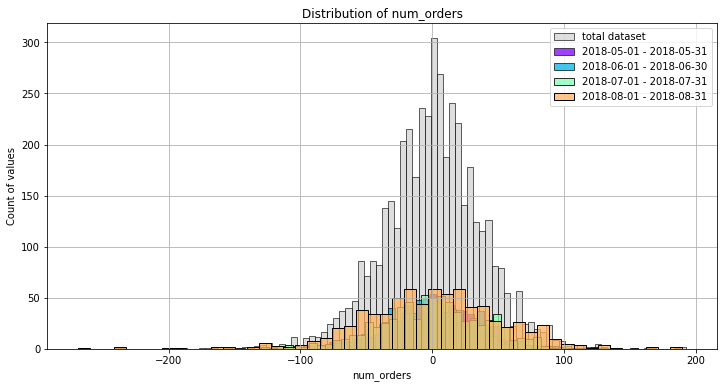

In [18]:
adfuller_test(y_sh, 0.05)
print()
compare_distributions(y_sh, splits=splits, tot=True)

Выведем коэффициенты автокорелляции для опредления оптимального размера окна для скользащего среднего и чаcтичной автокорелляции для размера признаков для авторегрессии

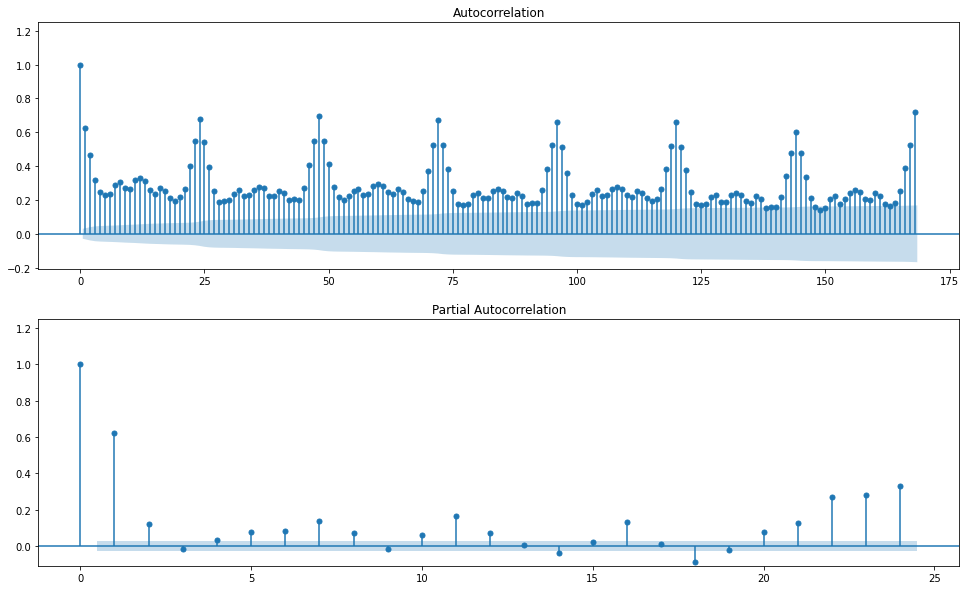

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16.5, 10))
plot_acf(y, ax=ax[0], lags=24*7, auto_ylims=True);
plot_pacf(y, ax=ax[1], lags=24, auto_ylims=True);



    Все коэффициенты автокорелляции выше порога значимости для сезонного инервала в 24 часа и даже для недельного интервала
    Для авторегрессии также можно взять суточный интервал



## Обучение

Подготовим функцию для генерирования новых признаков
Заложим возможность создания:

    Календарных признаков
    Скользящего среднего
    Разностей с предыдущими значениями, отстающими на заданное значение
    Отстающих значений

In [20]:
#def make_features(x, calendar_features:list = None, 
#                  p: int = 0, d: int = 0, q: int = None):
 
    #    df = pd.DataFrame(index=x.index)
#    # календарные признаки
#    if calendar_features:
#        for f in calendar_features:
#            try:
#                df[f] = getattr(x.index, f)
#            except:
#                print("Can't generate '{}' feature".format(f))
    # отстающие значения
#    for lag in range(1, p + 1):
#        df['p_%s' % lag] = x.shift(lag)
    # дифференцирование порядка d
#    if d > 0:
#        df['d_1']= x.shift(1) - x.shift(2)
#        if d > 1:
#            for order in range(2, d+1):
#                df['d_%s' % order] = df['d_%s' % (order-1)] - df['d_%s' % (order-1)].shift()
    # скользящее среднее
#    if q:
#        df['q_%s' % q] = x.shift().rolling(q).mean()

#    return df

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Ок, можно и такую функцию (смутно напоминает фичи Arima-моделей), хотя в тренажере была неплохая и весьма компактная. 
</div>  




Разделим целевую переменную на тестовую и тренировочную выборки, в дальнейшем по индексам этих выборок сможет разбить признаки на соответсвующие выборки


In [21]:
#y_train, y_test = train_test_split(y, shuffle=False, test_size=0.1)

<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Фичи важно создавать до разделения на выборки. Как минимум, так мы избежим дополнительного количества пропусков из-за смещения. Если создаем на всем датасете, то пропуски строк возникнут в самом начала датасета - наименее актуальных данных.

</div>



Переберём разные параметры для генерации новых признаков, посмотрим, какую метрику они дают на валидации. Чтобы обучение шло быстрее возьмём линейную регрессию


Переберём разные параметры для генерации новых признаков, посмотрим, какую метрику они дают на валидации. Чтобы обучение шло быстрее возьмём линейную регрессию

In [23]:
#def validate_params(model, p, d, q):
   
#    X = make_features(y, calendar_features=['weekday', 'hour'],
#                      p=p, d=d, q=q)
#    X_tr, X_val, y_tr, y_val = train_test_split(
#        X.loc[y_train.index], y_train, shuffle=False, test_size=0.1)
#    y_tr = y_tr[X_tr.notna().all(axis=1)]
#    X_tr.dropna(inplace=True)
#    model.fit(X_tr, y_tr)
#   return mse(y_val, model.predict(X_val), squared=False)

<div class="alert alert-block alert-danger">
<h2><x> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Хм, давай все-таки причешем код. В проекте правильно будет реализовать разделение на выборки один раз. У тебя как минимум три. Это серьезно усложняет восприятие кода, закладывает риски того, что модели будем обучать на разных данных и что если поправим в одном месте и забудем в другом, будет плохо работающий код на выходе. 
    

    
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
  
  
По признакам. Я не вполне понимаю теоретическую обоснованность сочетания подходов ARIMA и ML в одном проекте. Если ты объяснишь или дашь ссылку на материал, где объясняется полезность такого объедининя, буду признателен. То есть, это в целом работает, но чуть хуже, чем просто подавать признаки без преобразований, как было в тренажере.
    
Пока же мне кажется, что стоит следовать примерно тому порядку, который давался в теории. Там же приводили пример функции для создания фичей. Нас интересуют календарные фичи, лаги и скользящее среднее. По авторегрессии мы можем понять, что лагов нам нужно подать больше, фактически 168 будет отличным вариантом. Дифференцирование и прочее, конечно, будут в целом полезными признаками, но модель (допустим, регрессия) ту же информацию узнает из наших фичей, подобав им веса. То есть, какаого-то прироста качества мы здесь ожидать не будем.
    
Вот такую функцию предлагалось использовать в теории:
    
`def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour`
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data`
       
Я бы переписал код в этом варианте. Это будет проще, компактнее и эффективнее по качеству. Однако в целом твой вариант тоже решает поставленную задачу. Похожие подходы есть, когда, например, мы создаем фичи с помощью prophet, а затем применяем ML-методы для предсказания.


In [24]:
#p_list, d_list, q_list, rmse_list = [], [], [], []
#model = LinearRegression()
#for p in range(2,36,1):
#    for d in range(4):
#        for q in [6, 12, 24, 48, 72, 7*24]:
#            p_list.append(p)
#            d_list.append(d)
#            q_list.append(q)
#            rmse_list.append(validate_params(model, p, d, q))
#report = pd.DataFrame({'RMSE':rmse_list, 'p':p_list, 'd':d_list, 'q':q_list})

In [25]:
#plt.figure(figsize=(16,6))
#sns.lineplot(data=report, x='p', y='RMSE', hue='d',
#             palette=sns.color_palette("husl", 4))
#plt.grid()
#plt.show()
#plt.figure(figsize=(16, 6))
#sns.lineplot(data=report, x='p', y='RMSE', hue='q',
#             palette=sns.color_palette("husl", 6))
#plt.grid()
#plt.show()
#report.sort_values(by='RMSE').head(10)

Возьмём количество отстающих значений равным количеству часов в сутках - сезонность
Порядок дифференцирования равным 2.
Скользящее среднее вычислим за 24 часа (по количеству часов в сутках)

In [26]:
#X = make_features(y, calendar_features=['weekday', 'hour'],
#                  p=24, d=2, q=24)
# X = pd.DataFrame(StandardScaler().fit_transform(X),
#                  columns=X.columns, index=X.index)
#X_train, X_test = X.loc[y_train.index], X.loc[y_test.index]
#y_train = y_train[X_train.notna().all(axis=1)]
#X_train.dropna(inplace=True)

In [27]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [52]:
data = make_features(df, 24*7, 24)
data = data.dropna()

In [53]:
features = data.drop(columns=['num_orders'])
target = data['num_orders'] 

In [54]:
X_train, X_test = train_test_split(features, shuffle=False, test_size=0.1)

In [55]:
y_train, y_test = train_test_split(target, shuffle=False, test_size=0.1)

Обучим модели RandomForestRegressor, CatBoostRegressor, LGBMRegressor на сгенерированных признаках

In [47]:
tscv = TimeSeriesSplit(n_splits=3, test_size=24*7*3)

def best_cv_models(grid, count):
    ''' Выводит таблицу с рейтингом моделей, показавших наилучшие значения RMSE на кроссвалидации.

    Принимает  
        : `grid` - результат GridSearchCV после fit(), 
        : `count` - количество лучших моделей для вывода
    Возвращает : pd.DataFrame c параметрами моделей
    '''

    print('Estimator: {}'.format(grid.estimator))
    print('Tested {} models. Splits: {}'.format(
        len(grid.cv_results_['params']), grid.cv))
    print('Best RMSE = {}\n'.format((-grid.best_score_) ** 0.5))
    best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]
    return pd.DataFrame({
        'RMSE test': (-grid.cv_results_['mean_test_score'][best_idx])**0.5,
        'RMSE train': (-grid.cv_results_['mean_train_score'][best_idx])**0.5,
        'fit time, s': grid.cv_results_['mean_fit_time'][best_idx],
        'score time, s': grid.cv_results_['mean_score_time'][best_idx]}
    ).join(pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))


common_cv_params = {'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': tscv}

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 По схеме кросс-валидации и по метрикам все отлично.
</div>  


In [48]:
for train_ind, test_ind in tscv.split(y):
    print("Трэйн: {}, Тест: {}"
        .format(train_ind[::len(train_ind)-1],test_ind[::len(test_ind)-1]))

24*7*3, y_test.shape

Трэйн: [   0 2903], Тест: [2904 3407]
Трэйн: [   0 3407], Тест: [3408 3911]
Трэйн: [   0 3911], Тест: [3912 4415]


(504, (442,))

**RandomForest**

In [57]:
%%time
params = {'max_depth': range(2, 21, 2),
          'n_estimators': range(10, 101, 10)}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                           param_grid=params, n_jobs=-1, **common_cv_params)
grid_rf.fit(X_train, y_train)

best_cv_models(grid_rf, 10)

Estimator: RandomForestRegressor(random_state=42)
Tested 100 models. Splits: TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=504)
Best RMSE = 25.159134253951045

CPU times: user 38min 21s, sys: 2.61 s, total: 38min 24s
Wall time: 38min 25s


,RMSE test,RMSE train,"fit time, s","score time, s",max_depth,n_estimators
0,25.159134,7.333009,19.172573,0.024007,20,100
1,25.182674,7.485724,18.762998,0.020620,16,100
2,25.197475,7.371963,19.175115,0.022764,18,100
3,25.207918,10.320882,14.736426,0.016714,10,100
4,25.209438,7.515480,14.894401,0.017659,16,80
5,25.209891,7.354909,17.470938,0.018083,20,90
6,25.221362,10.405194,7.449004,0.009886,10,50
7,25.222092,10.345092,11.993225,0.013652,10,80
8,25.223382,7.504252,16.899486,0.017651,16,90
9,25.226945,7.821635,17.910217,0.018523,14,100


**CatBoost**

In [58]:
%%time
params = {'max_depth': [4, 6, 8],
          'learning_rate': [0.05, 0.1, 0.2]}
grid_ctb = GridSearchCV(CatBoostRegressor(loss_function='RMSE',
                                          random_state=RANDOM_STATE,
                                          verbose=False),
                       param_grid=params, n_jobs=-1, **common_cv_params)
grid_ctb.fit(X_train, y_train)

best_cv_models(grid_ctb, 10)

Estimator: <catboost.core.CatBoostRegressor object at 0x7f1a0833e6d0>
Tested 9 models. Splits: TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=504)
Best RMSE = 24.960149278272304

CPU times: user 21min 3s, sys: 5.13 s, total: 21min 9s
Wall time: 21min 46s


,RMSE test,RMSE train,"fit time, s","score time, s",learning_rate,max_depth
0,24.960149,6.596827,30.041564,0.008019,0.05,6
1,25.071418,3.219644,95.621259,0.009147,0.05,8
2,25.236109,2.542198,31.079280,0.009428,0.10,6
3,25.266054,10.793557,12.082342,0.038232,0.05,4
4,25.546511,0.651472,97.758796,0.008853,0.10,8
5,25.588359,6.484484,12.088040,0.007996,0.10,4
6,26.129161,2.734617,12.451693,0.007964,0.20,4
7,26.156819,0.038162,100.879459,0.008851,0.20,8
8,26.200759,0.504492,31.045144,0.008542,0.20,6


**LightGBM**

In [59]:
%%time
params = {'max_depth': [10, 20],
          'learning_rate': [0.05, 0.1],
          'num_leaves': [50, 100, 250],
          'n_estimators': [200, 500]}
grid_lgb = GridSearchCV(LGBMRegressor(metric='rmse',
                                      random_state=RANDOM_STATE),
                        param_grid=params, n_jobs=-1, **common_cv_params)
grid_lgb.fit(X_train, y_train)

best_cv_models(grid_lgb, 10)

Estimator: LGBMRegressor(metric='rmse', random_state=42)
Tested 24 models. Splits: TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=504)
Best RMSE = 24.76112215902296

CPU times: user 28min 19s, sys: 10.5 s, total: 28min 29s
Wall time: 28min 39s


,RMSE test,RMSE train,"fit time, s","score time, s",learning_rate,max_depth,n_estimators,num_leaves
0,24.761122,1.184428,53.134252,0.065885,0.05,20,500,100
1,24.804144,2.631125,15.068795,0.005902,0.05,20,200,100
2,24.877282,1.181455,43.772272,0.094239,0.05,20,500,250
3,24.896459,2.608788,16.103243,0.030466,0.05,20,200,250
4,24.976071,3.977042,16.701544,0.058587,0.05,10,200,250
5,24.998143,3.735011,10.997514,0.005402,0.05,20,200,50
6,25.025729,3.989459,9.867331,0.032471,0.05,10,200,100
7,25.030556,1.566111,19.796362,0.037057,0.05,10,500,250
8,25.039775,1.063297,53.060859,0.036309,0.05,20,500,50
9,25.063753,1.539466,20.302298,0.089843,0.05,10,500,100


In [60]:
report = pd.DataFrame({'RandomForest': (-grid_rf.best_score_)**0.5,
                       'CatBoost': (-grid_ctb.best_score_)**0.5,
                       'LightGBM': (-grid_lgb.best_score_)**0.5}, index=['RMSE valid'])

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 В этой части все ок. 
</div>  


## Тестирование

In [61]:


def test_model(model, X_train, y_train, X_test, y_test):
    ''' 
    - Обучение модели `model` на выборках `X_train`, `y_train`
    - Предсказание обученной модели на наборе `X_test`
    - Вычисление RMSE на полученных предсказаниях и наборе `y_test`
    
    Возвращает RMSE, время обучения, время пердсказаний в виде словаря
    '''
    # обучение
    t_beg = time.time()
    model.fit(X_train, y_train)
    time_fit = time.time() - t_beg
    # предсказания
    t_beg = time.time()
    y_pred = model.predict(X_test)
    time_predict = time.time() - t_beg
    # метрика
    rmse = mse(y_test, y_pred, squared=False)

    return {'RMSE test': rmse,
            'fit time, s': time_fit,
            'predict time, s':time_predict}



In [62]:
models = {
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE,
                                          **grid_rf.best_params_),
    'CatBoost': CatBoostRegressor(loss_function='RMSE',
                                  random_state=RANDOM_STATE,
                                  verbose=False, **grid_ctb.best_params_),
    'LightGBM': LGBMRegressor(metric='rmse', random_state=RANDOM_STATE,
                              **grid_lgb.best_params_)}

scores_table = {}
for name, model in tqdm(models.items()):
    scores_table[name] = test_model(
        model, X_train, y_train, X_test, y_test)

report = pd.concat([report, pd.DataFrame(scores_table)])
report

  0%|          | 0/3 [00:00<?, ?it/s]

,RandomForest,CatBoost,LightGBM
RMSE valid,25.159134,24.960149,24.761122
RMSE test,38.856415,36.890612,36.940471
"fit time, s",27.441591,36.845934,87.643373
"predict time, s",0.017684,0.007387,0.083981


При рассмотренных параметрах генерирования признаков и обучения моделей лучше всего себя показал CatBoost, он выигрывает по точности и по скорости предсказаний. LightGBM лучше всего показал себя по скорости обучения.

Выведем для сравнения временные ряды, предсказанные LightGBM и CatBoost на одном графике с тестовым набором

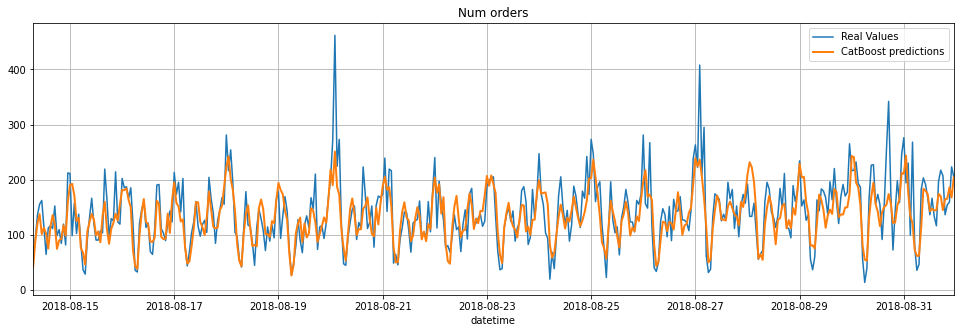

In [63]:
pred_lgbm = pd.Series(models['CatBoost'].predict(X_test), index=y_test.index)
plt.figure(figsize=(16.5,5))
sns.lineplot(y=y_test.values, x=y_test.index)
sns.lineplot(y=pred_lgbm.values, x=pred_lgbm.index, linewidth=2)
plt.grid()
plt.xlim(y_test.index.min(), y_test.index.max())
plt.legend(['Real Values', 'CatBoost predictions'])
plt.title('Num orders');

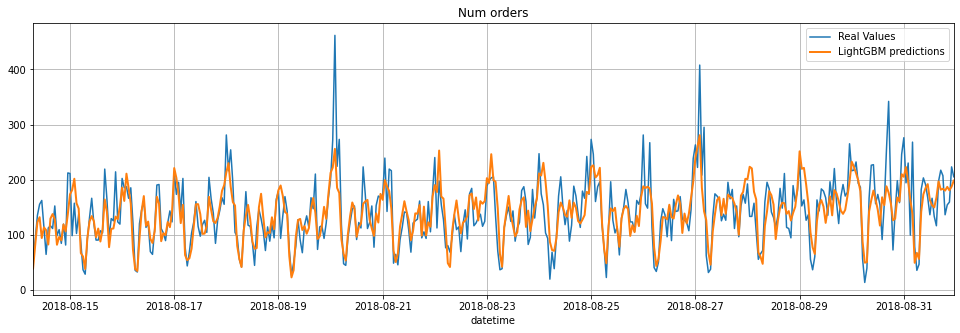

In [64]:
pred_lgbm = pd.Series(models['LightGBM'].predict(X_test), index=y_test.index)
plt.figure(figsize=(16.5,5))
sns.lineplot(y=y_test.values, x=y_test.index)
sns.lineplot(y=pred_lgbm.values, x=pred_lgbm.index, linewidth=2)
plt.grid()
plt.xlim(y_test.index.min(), y_test.index.max())
plt.legend(['Real Values', 'LightGBM predictions'])
plt.title('Num orders');

CatBoost в целом немного лучше подстаивается под максимальные значения

Сравним полученные значения с RMSE при предсказании предыдущим значением ряда

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Согласен. Основные проблемы у моделей именно с пиковыми значениями. Однако похоже, что все модели неплохо предсказывают сам факт повышенного спроса на такси, что и важно заказчику.
</div>  
    


In [65]:
y_prev = y_test.shift()
y_prev.iloc[0] = y_train.iloc[-1]

print("RMSE:", mse(y_test, y_prev, squared=False))

RMSE: 58.819724582830204


Модели предсказывают лучше, чем значения из прошлого

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Наши модели адекватны.
</div>  
    


**Вывод**

Были проанализированы временные данные количества заказов такси:
Данные сильно зашумлены, имеют высокую дисперсию, тренд на возрастание, суточную и еженедельную сезонность.

Созданы признаки для горизонта пргнозирования в один шаг:

    Календарные: месяц, день недели, число, час, отстающие значения за предыдущие 24 часа,  
    скользящее среднее, и интегральная величина.

Обучены модели регрессии:

    подобраны оптимальные параметры
    заданное значение RMSE достигнуто.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Пишешь, что созданы признаки в том числе месяца. Выше верно не создаешь их, здесь нужно тогда убрать месяц в выводе.
    
Наши календарные признаки подчеркивают сезонность. Относительно сезонности признаки идут на один уровень ниже. Если у нас суточная сезонность, то логично создавать признак часа (час одного дня похож на тот же час другого), если недельная - день недели. Так как данные за полгода, признак месяца нам не нужен.
       
</div> 

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проверке**

У тебя получился очень хороший проект с интересным подходом. Неплохой выбор моделей для обучения, достаточно подробная исследовательская часть. Однако есть и что доработать:

* Важно реализовать разделение на выборки в проекте один раз. Признаки нужно создавать до разделения на выборки.

Рекомендую также воспользоваться подходом, который предлагался в тренажере, а также значительно увеличить количество лагов (вплоть до 168).

**Желаю удачи и жду твой проект на повторное ревью!**😉

</div>



<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за доработку. Критичных комментариев нет. 
    
Если что-то пропустил или остались вопросы, напиши на телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48